In [ ]:
# Shalev Yosefashvili 322582008
# Dimitry todoseyev 322810060


Using device: cpu
Classes found: ['Happy', 'Sad']
Training images: 480
Validation images: 120


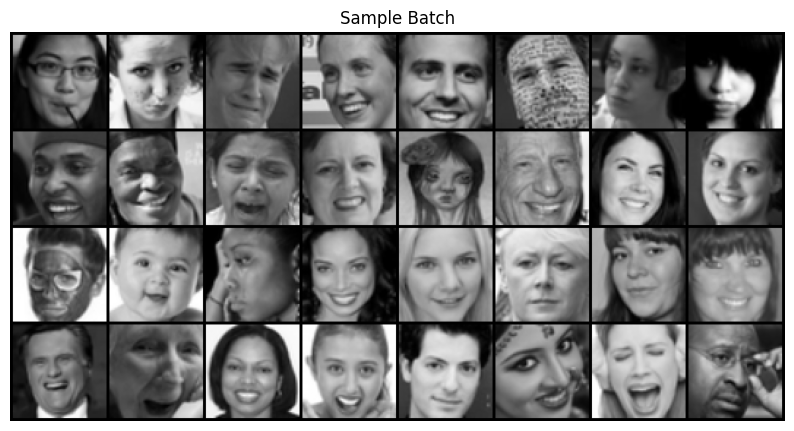

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# 1. Device Configuration (Use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Data Transformations
# Unlike fastai's 'item_tfms', we define these explicitly.
# We resize to 64x64 to keep the model lightweight for "Training from Scratch".
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization values

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),        # Convert to PyTorch Tensor (0-1 range)
    transforms.Normalize(*stats)  # Normalize to [-1, 1] range
])

# 3. Load Dataset
# Assuming your folder structure is 'data/Happy' and 'data/Sad'
data_path = "data"

try:
    full_dataset = ImageFolder(root=data_path, transform=transform)
    print(f"Classes found: {full_dataset.classes}")
except FileNotFoundError:
    print("Error: Data folder not found. Please ensure 'data' folder exists.")

# 4. Split into Train and Validation (80% Train, 20% Val)
# fastai does this with 'valid_pct=0.2'
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

# 5. Create DataLoaders
# These are the iterators that feed data to the GPU in batches
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Helper function to show a batch (Sanity Check)
def show_batch(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(10, 10))
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Sample Batch")
    plt.axis('off')
    plt.show()

# Run sanity check
show_batch(train_loader)

In [3]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()

        # Layer 1: Conv -> ReLU -> MaxPool
        # Input: 3 channels (RGB), Output: 16 filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Image size goes 64 -> 32
        self.relu = nn.ReLU()

        # Layer 2: Conv -> ReLU -> MaxPool
        # Input: 16, Output: 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Pool again: Image size goes 32 -> 16

        # Fully Connected Layers (Classifier)
        # 32 channels * 16 * 16 image size
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2) # Output: 2 classes (Happy, Sad)

    def forward(self, x):
        # Pass through Layer 1
        x = self.pool(self.relu(self.conv1(x)))
        # Pass through Layer 2
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten for Fully Connected layer
        x = x.view(x.size(0), -1)

        # Classification
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_a = ShallowCNN().to(device)
print(model_a)

ShallowCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train() # Set mode to training (enables dropout, batchnorm if present)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 1. Zero the parameter gradients
            optimizer.zero_grad()

            # 2. Forward pass
            outputs = model(images)

            # 3. Calculate Loss
            loss = criterion(outputs, labels)

            # 4. Backward pass (Backprop)
            loss.backward()

            # 5. Optimizer step (Update weights)
            optimizer.step()

            # Track stats
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train

        # --- VALIDATION PHASE ---
        model.eval() # Set mode to evaluation
        correct_val = 0
        total_val = 0

        with torch.no_grad(): # No need to track gradients for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val

        # Store history
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_acc_history, val_acc_history

In [5]:
# Experiment 1 Setup: Shallow CNN + Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

print("Starting training for Shallow CNN...")
hist_a_train, hist_a_val = train_model(model_a, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Starting training for Shallow CNN...
Epoch [1/15], Loss: 0.7216, Train Acc: 52.29%, Val Acc: 52.50%
Epoch [2/15], Loss: 0.6737, Train Acc: 56.67%, Val Acc: 54.17%
Epoch [3/15], Loss: 0.6383, Train Acc: 64.17%, Val Acc: 60.83%
Epoch [4/15], Loss: 0.5907, Train Acc: 68.54%, Val Acc: 63.33%
Epoch [5/15], Loss: 0.5431, Train Acc: 72.71%, Val Acc: 60.00%
Epoch [6/15], Loss: 0.5061, Train Acc: 76.25%, Val Acc: 65.83%
Epoch [7/15], Loss: 0.4012, Train Acc: 83.75%, Val Acc: 71.67%
Epoch [8/15], Loss: 0.3352, Train Acc: 86.04%, Val Acc: 72.50%
Epoch [9/15], Loss: 0.2613, Train Acc: 92.29%, Val Acc: 70.83%
Epoch [10/15], Loss: 0.1673, Train Acc: 95.21%, Val Acc: 67.50%
Epoch [11/15], Loss: 0.1143, Train Acc: 97.71%, Val Acc: 67.50%
Epoch [12/15], Loss: 0.0664, Train Acc: 98.54%, Val Acc: 71.67%
Epoch [13/15], Loss: 0.0437, Train Acc: 99.58%, Val Acc: 66.67%
Epoch [14/15], Loss: 0.0354, Train Acc: 99.17%, Val Acc: 74.17%
Epoch [15/15], Loss: 0.0194, Train Acc: 99.79%, Val Acc: 70.00%


In [6]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # Layer 1: Input (3) -> Output (32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 2: Input (32) -> Output (64)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Layer 3: Input (64) -> Output (128)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        # After 3 pooling layers (64 -> 32 -> 16 -> 8), image size is 8x8
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # 64 -> 32
        x = self.pool(self.relu(self.conv2(x))) # 32 -> 16
        x = self.pool(self.relu(self.conv3(x))) # 16 -> 8

        x = x.view(x.size(0), -1) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_b = DeepCNN().to(device)
print("Deep CNN created.")

Deep CNN created.


In [7]:
# Experiment 2 Setup: Deep CNN + Adam
optimizer_b = optim.Adam(model_b.parameters(), lr=0.001)

print("Starting training for Deep CNN (Model B)...")
hist_b_train, hist_b_val = train_model(model_b, train_loader, val_loader, criterion, optimizer_b, num_epochs=15)

Starting training for Deep CNN (Model B)...
Epoch [1/15], Loss: 0.6951, Train Acc: 53.12%, Val Acc: 47.50%
Epoch [2/15], Loss: 0.6923, Train Acc: 50.62%, Val Acc: 47.50%
Epoch [3/15], Loss: 0.6865, Train Acc: 52.92%, Val Acc: 51.67%
Epoch [4/15], Loss: 0.6751, Train Acc: 58.12%, Val Acc: 55.83%
Epoch [5/15], Loss: 0.6358, Train Acc: 62.92%, Val Acc: 55.00%
Epoch [6/15], Loss: 0.5977, Train Acc: 67.50%, Val Acc: 52.50%
Epoch [7/15], Loss: 0.5732, Train Acc: 72.50%, Val Acc: 62.50%
Epoch [8/15], Loss: 0.5227, Train Acc: 75.62%, Val Acc: 64.17%
Epoch [9/15], Loss: 0.4751, Train Acc: 76.04%, Val Acc: 65.00%
Epoch [10/15], Loss: 0.4104, Train Acc: 83.33%, Val Acc: 67.50%
Epoch [11/15], Loss: 0.3213, Train Acc: 86.88%, Val Acc: 65.83%
Epoch [12/15], Loss: 0.2582, Train Acc: 87.71%, Val Acc: 64.17%
Epoch [13/15], Loss: 0.1738, Train Acc: 93.75%, Val Acc: 70.83%
Epoch [14/15], Loss: 0.1180, Train Acc: 95.42%, Val Acc: 64.17%
Epoch [15/15], Loss: 0.0835, Train Acc: 96.88%, Val Acc: 66.67%


In [8]:
# --- EXPERIMENT 3: Compare Optimization Algorithms (SGD) ---
# We take the winner (Model A architecture) but swap Adam for SGD.
# SGD often generalizes better than Adam but takes longer to converge.

model_a_sgd = ShallowCNN().to(device) # Re-initialize a fresh model
optimizer_sgd = optim.SGD(model_a_sgd.parameters(), lr=0.01, momentum=0.9)

print("--- Experiment 3: Shallow CNN with SGD Optimizer ---")
hist_sgd_train, hist_sgd_val = train_model(model_a_sgd, train_loader, val_loader, criterion, optimizer_sgd, num_epochs=15)


# --- EXPERIMENT 4: Add Batch Normalization (Step 2) ---
# We modify the Deep CNN (Model B) to include BatchNorm layers.
# This should fix the slow start and allow it to train faster/better.

class DeepCNN_BN(nn.Module):
    def __init__(self):
        super(DeepCNN_BN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Add Batch Norm
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Add Batch Norm

        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Add Batch Norm

        # Fully Connected
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        # Order: Conv -> BN -> ReLU -> Pool
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_bn = DeepCNN_BN().to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

print("\n--- Experiment 4: Deep CNN with Batch Normalization ---")
hist_bn_train, hist_bn_val = train_model(model_bn, train_loader, val_loader, criterion, optimizer_bn, num_epochs=15)

--- Experiment 3: Shallow CNN with SGD Optimizer ---
Epoch [1/15], Loss: 0.6935, Train Acc: 51.04%, Val Acc: 47.50%
Epoch [2/15], Loss: 0.6843, Train Acc: 54.58%, Val Acc: 56.67%
Epoch [3/15], Loss: 0.6640, Train Acc: 62.71%, Val Acc: 59.17%
Epoch [4/15], Loss: 0.6472, Train Acc: 62.08%, Val Acc: 57.50%
Epoch [5/15], Loss: 0.6171, Train Acc: 65.62%, Val Acc: 59.17%
Epoch [6/15], Loss: 0.5946, Train Acc: 68.96%, Val Acc: 59.17%
Epoch [7/15], Loss: 0.5808, Train Acc: 69.58%, Val Acc: 59.17%
Epoch [8/15], Loss: 0.5630, Train Acc: 71.04%, Val Acc: 56.67%
Epoch [9/15], Loss: 0.5235, Train Acc: 74.38%, Val Acc: 60.83%
Epoch [10/15], Loss: 0.4802, Train Acc: 77.71%, Val Acc: 63.33%
Epoch [11/15], Loss: 0.4436, Train Acc: 81.67%, Val Acc: 59.17%
Epoch [12/15], Loss: 0.3999, Train Acc: 80.21%, Val Acc: 61.67%
Epoch [13/15], Loss: 0.4215, Train Acc: 82.50%, Val Acc: 67.50%
Epoch [14/15], Loss: 0.3425, Train Acc: 84.79%, Val Acc: 60.00%
Epoch [15/15], Loss: 0.3439, Train Acc: 83.96%, Val Acc: 68.

In [9]:
# 1. New Data Transforms with Augmentation
train_transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(10),           # Rotate +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Slight color changes
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Validation stays simple (just Resize + Normalize)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# 2. Reload Datasets with new transforms
# We need to recreate the datasets to apply these new transforms
train_dataset_aug = ImageFolder(root=data_path, transform=train_transform_aug)
# Note: For proper validation, we usually split indices, but for simplicity here
# we will just apply the augmentation to the training portion.
# To keep it clean, let's re-split using the same logic but with new transforms.

# (Simplified approach for this assignment context: Reload and split)
full_dataset_aug = ImageFolder(root=data_path, transform=train_transform_aug)
train_size = int(0.8 * len(full_dataset_aug))
val_size = len(full_dataset_aug) - train_size

# specific split for augmented training
train_dataset_final, _ = random_split(full_dataset_aug, [train_size, val_size])

# specific split for clean validation (hacky but works for this scope)
full_dataset_clean = ImageFolder(root=data_path, transform=val_transform)
_, val_dataset_final = random_split(full_dataset_clean, [train_size, val_size])

train_loader_aug = DataLoader(train_dataset_final, batch_size=32, shuffle=True)
val_loader_clean = DataLoader(val_dataset_final, batch_size=32, shuffle=False)

In [10]:
class DeepCNN_Reg(nn.Module):
    def __init__(self):
        super(DeepCNN_Reg, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout Layer (drops 50% of neurons)
        self.dropout = nn.Dropout(0.5)

        # Fully Connected
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        # Apply Dropout before the fully connected layer
        x = self.dropout(x)

        x = self.relu(self.fc1(x))
        x = self.dropout(x) # Optional: Dropout between FC layers too
        x = self.fc2(x)
        return x

model_reg = DeepCNN_Reg().to(device)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

print("\n--- Experiment 5: Deep CNN + BatchNorm + Dropout + Augmentation ---")
hist_reg_train, hist_reg_val = train_model(model_reg, train_loader_aug, val_loader_clean, criterion, optimizer_reg, num_epochs=20)


--- Experiment 5: Deep CNN + BatchNorm + Dropout + Augmentation ---
Epoch [1/20], Loss: 1.5170, Train Acc: 50.62%, Val Acc: 55.83%
Epoch [2/20], Loss: 0.9554, Train Acc: 55.00%, Val Acc: 60.00%
Epoch [3/20], Loss: 0.7419, Train Acc: 55.21%, Val Acc: 55.83%
Epoch [4/20], Loss: 0.6924, Train Acc: 52.92%, Val Acc: 55.83%
Epoch [5/20], Loss: 0.6839, Train Acc: 58.75%, Val Acc: 65.00%
Epoch [6/20], Loss: 0.6861, Train Acc: 54.79%, Val Acc: 65.00%
Epoch [7/20], Loss: 0.6656, Train Acc: 60.21%, Val Acc: 62.50%
Epoch [8/20], Loss: 0.6558, Train Acc: 60.00%, Val Acc: 61.67%
Epoch [9/20], Loss: 0.6688, Train Acc: 62.50%, Val Acc: 64.17%
Epoch [10/20], Loss: 0.6743, Train Acc: 60.21%, Val Acc: 67.50%
Epoch [11/20], Loss: 0.6546, Train Acc: 59.79%, Val Acc: 67.50%
Epoch [12/20], Loss: 0.6540, Train Acc: 61.67%, Val Acc: 62.50%
Epoch [13/20], Loss: 0.6548, Train Acc: 62.08%, Val Acc: 70.00%
Epoch [14/20], Loss: 0.6426, Train Acc: 62.29%, Val Acc: 69.17%
Epoch [15/20], Loss: 0.6374, Train Acc: 61.0

In [11]:
# --- STEP 4: PRETRAIN ON CIFAR-10 ---

print("Downloading CIFAR-10...")

# 1. Prepare CIFAR Data (Resize to 64x64 to match our architecture)
cifar_stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
cifar_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(*cifar_stats)
])

# Download Training Data
cifar_train = torchvision.datasets.CIFAR10(root='./data_cifar', train=True, download=True, transform=cifar_transform)
# We use a subset (10,000 images) to save time, or use full (50,000) if you have time.
# Let's use the full set for better features, it takes about 1-2 mins per epoch on GPU.
cifar_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)

print(f"CIFAR-10 loaded. Images: {len(cifar_train)}")

# 2. Initialize Model B (Deep CNN)
# We use the clean DeepCNN (without heavy dropout) for pretraining to learn features fast.
pretrained_model = DeepCNN().to(device)

# 3. Modify the Output Layer for 10 Classes (CIFAR has 10 classes)
# The original defined 'self.fc2 = nn.Linear(256, 2)'
# We overwrite it:
pretrained_model.fc2 = nn.Linear(256, 10).to(device)

# 4. Train on CIFAR
criterion_cifar = nn.CrossEntropyLoss()
optimizer_cifar = optim.Adam(pretrained_model.parameters(), lr=0.001)

print("Starting Pretraining on CIFAR-10...")
# We use a simplified loop just for printing loss
for epoch in range(5): # 5 Epochs is enough to learn edges/shapes
    pretrained_model.train()
    running_loss = 0.0
    for images, labels in cifar_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_cifar.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion_cifar(outputs, labels)
        loss.backward()
        optimizer_cifar.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5] CIFAR Loss: {running_loss/len(cifar_loader):.4f}")

print("Pretraining Complete!")

# 5. Save the Weights
torch.save(pretrained_model.state_dict(), "cifar_pretrained.pth")
print("Weights saved to 'cifar_pretrained.pth'")

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


CIFAR-10 loaded. Images: 50000
Starting Pretraining on CIFAR-10...
Epoch [1/5] CIFAR Loss: 1.3421
Epoch [2/5] CIFAR Loss: 0.9004
Epoch [3/5] CIFAR Loss: 0.6821
Epoch [4/5] CIFAR Loss: 0.5078
Epoch [5/5] CIFAR Loss: 0.3484
Pretraining Complete!
Weights saved to 'cifar_pretrained.pth'


In [12]:
# --- STEP 5: FINE-TUNE ON HAPPY/SAD ---

# 1. Initialize a fresh model
finetune_model = DeepCNN().to(device)

# 2. Match the structure to the saved weights (10 classes)
finetune_model.fc2 = nn.Linear(256, 10).to(device)

# 3. Load the weights
finetune_model.load_state_dict(torch.load("cifar_pretrained.pth"))
print("Pretrained weights loaded successfully.")

# 4. Surgery: Replace the final layer for OUR 2 classes
# This resets the weights of ONLY this layer. The rest of the network keeps the "smart" CIFAR weights.
finetune_model.fc2 = nn.Linear(256, 2).to(device)

# 5. Define Optimizer
# We use a slightly smaller learning rate (0.0005) so we don't break the pre-learned features too fast.
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=0.0005)

print("\n--- Experiment 6: Fine-Tuning Pretrained Model ---")
# Use the Augmented Training set (train_loader_aug) and Clean Validation (val_loader_clean)
hist_ft_train, hist_ft_val = train_model(finetune_model, train_loader_aug, val_loader_clean, criterion, optimizer_ft, num_epochs=15)

Pretrained weights loaded successfully.

--- Experiment 6: Fine-Tuning Pretrained Model ---
Epoch [1/15], Loss: 0.7261, Train Acc: 58.12%, Val Acc: 69.17%
Epoch [2/15], Loss: 0.6111, Train Acc: 64.79%, Val Acc: 78.33%
Epoch [3/15], Loss: 0.5452, Train Acc: 75.42%, Val Acc: 73.33%
Epoch [4/15], Loss: 0.4890, Train Acc: 76.04%, Val Acc: 80.00%
Epoch [5/15], Loss: 0.4484, Train Acc: 77.29%, Val Acc: 85.00%
Epoch [6/15], Loss: 0.4001, Train Acc: 82.92%, Val Acc: 82.50%
Epoch [7/15], Loss: 0.3364, Train Acc: 85.21%, Val Acc: 89.17%
Epoch [8/15], Loss: 0.3081, Train Acc: 86.04%, Val Acc: 88.33%
Epoch [9/15], Loss: 0.2799, Train Acc: 89.58%, Val Acc: 86.67%
Epoch [10/15], Loss: 0.2617, Train Acc: 91.04%, Val Acc: 90.83%
Epoch [11/15], Loss: 0.1989, Train Acc: 92.92%, Val Acc: 94.17%
Epoch [12/15], Loss: 0.1705, Train Acc: 93.96%, Val Acc: 95.00%
Epoch [13/15], Loss: 0.1406, Train Acc: 96.25%, Val Acc: 94.17%
Epoch [14/15], Loss: 0.1415, Train Acc: 95.83%, Val Acc: 91.67%
Epoch [15/15], Loss: 

In [13]:
from torchvision.models import resnet50, ResNet50_Weights

# 1. Load ResNet50 with ImageNet weights
print("Downloading ResNet50...")
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights).to(device)

# 2. Freeze all layers (We only want to train the final classifier)
for param in resnet.parameters():
    param.requires_grad = False

# 3. Replace the final layer (ResNet calls it 'fc')
# ResNet50's last layer has 2048 input features. We want 2 outputs.
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2).to(device)

# 4. Define Optimizer
# We only pass 'resnet.fc.parameters()' because the rest are frozen!
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)

print("\n--- Experiment 7: ResNet50 Transfer Learning ---")
hist_res_train, hist_res_val = train_model(resnet, train_loader_aug, val_loader_clean, criterion, optimizer_resnet, num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]



--- Experiment 7: ResNet50 Transfer Learning ---
Epoch [1/10], Loss: 0.7013, Train Acc: 56.04%, Val Acc: 56.67%
Epoch [2/10], Loss: 0.6465, Train Acc: 60.00%, Val Acc: 61.67%
Epoch [3/10], Loss: 0.6195, Train Acc: 65.83%, Val Acc: 65.00%
Epoch [4/10], Loss: 0.6057, Train Acc: 67.92%, Val Acc: 74.17%
Epoch [5/10], Loss: 0.6006, Train Acc: 69.58%, Val Acc: 76.67%
Epoch [6/10], Loss: 0.5758, Train Acc: 71.67%, Val Acc: 76.67%
Epoch [7/10], Loss: 0.5992, Train Acc: 68.12%, Val Acc: 80.00%
Epoch [8/10], Loss: 0.5682, Train Acc: 71.25%, Val Acc: 78.33%
Epoch [9/10], Loss: 0.5660, Train Acc: 72.08%, Val Acc: 79.17%
Epoch [10/10], Loss: 0.5405, Train Acc: 74.17%, Val Acc: 74.17%


In [14]:
# --- EXPERIMENT 8: UNFREEZING ResNet50 (Fine-Tuning) ---

# 1. Unfreeze all layers
for param in resnet.parameters():
    param.requires_grad = True

# 2. Use a much smaller learning rate
# We don't want to destroy the pre-trained weights, just nudge them.
optimizer_resnet_unfrozen = optim.Adam(resnet.parameters(), lr=1e-4) # 10x smaller LR

print("\n--- Experiment 8: Fine-Tuning ResNet50 (Unfrozen) ---")
hist_res_unfrozen_train, hist_res_unfrozen_val = train_model(
    resnet,
    train_loader_aug,
    val_loader_clean,
    criterion,
    optimizer_resnet_unfrozen,
    num_epochs=10
)


--- Experiment 8: Fine-Tuning ResNet50 (Unfrozen) ---
Epoch [1/10], Loss: 0.5520, Train Acc: 71.04%, Val Acc: 81.67%
Epoch [2/10], Loss: 0.5024, Train Acc: 74.58%, Val Acc: 82.50%
Epoch [3/10], Loss: 0.4406, Train Acc: 80.21%, Val Acc: 89.17%
Epoch [4/10], Loss: 0.3950, Train Acc: 81.88%, Val Acc: 87.50%
Epoch [5/10], Loss: 0.3376, Train Acc: 85.21%, Val Acc: 90.83%
Epoch [6/10], Loss: 0.2714, Train Acc: 90.83%, Val Acc: 91.67%
Epoch [7/10], Loss: 0.2611, Train Acc: 89.58%, Val Acc: 93.33%
Epoch [8/10], Loss: 0.2276, Train Acc: 91.46%, Val Acc: 92.50%
Epoch [9/10], Loss: 0.2204, Train Acc: 94.17%, Val Acc: 95.83%
Epoch [10/10], Loss: 0.1359, Train Acc: 96.46%, Val Acc: 95.83%
